## Testing effects of soil and fire properties on soil microbial communities
## This notebook provides the statistical analyses reported in Table 1

In [2]:
# Loading packages
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

In [3]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

In [4]:
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
ps.hell = transform_sample_counts(ps, function(x) (x / sum(x))^0.5)
# Hellinger Transformation: "Particularly suited to species abundance data, 
    # this transformation gives low weights to variables with low counts and many zeros. 
    # The transformation itself comprises dividing each value in a data matrix by its row sum, 
    # and taking the square root of the quotient.

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,4,0.01866904,0.004667259,1.229392,0.3035474
Residuals,96,0.36445400,0.003796396,NA,NA


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                   diff         lwr        upr     p adj
Jack Pine-Black Spruce      0.012678404 -0.04005505 0.06541186 0.9626816
Mixedwood-Black Spruce      0.022602134 -0.03042967 0.07563394 0.7599410
Open Wetland-Black Spruce   0.034955151 -0.02561144 0.09552174 0.4981577
Treed Wetland-Black Spruce -0.014148107 -0.08832673 0.06003052 0.9840210
Mixedwood-Jack Pine         0.009923729 -0.03394970 0.05379716 0.9700535
Open Wetland-Jack Pine      0.022276747 -0.03045671 0.07501020 0.7658347
Treed Wetland-Jack Pine    -0.026826511 -0.09476010 0.04110708 0.8072021
Open Wetland-Mixedwood      0.012353017 -0.04067879 0.06538482 0.9666939
Treed Wetland-Mixedwood    -0.036750240 -0.10491569 0.03141521 0.5656965
Treed Wetland-Open Wetland -0.049103258 -0.12328188 0.02507536 0.3567420


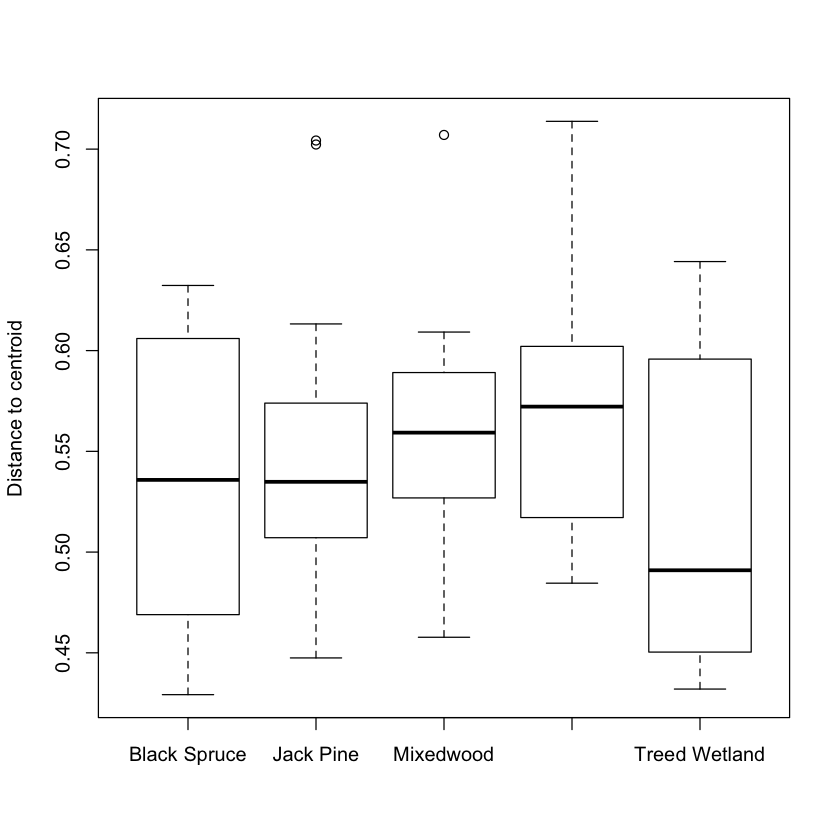

In [5]:
physeq = ps.hell
#physeq = subset_samples(physeq,Land_Class=="Wetland")
#physeq = subset_samples(physeq,Land_Class=="Upland")

df = as(sample_data(physeq), "data.frame")

d = distance(physeq, method = "bray", weighted=TRUE)
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Veg_Comm)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here for the different vegetation communities - no significant differences.
# Looks generally okay for Severity_Class
# Land_Class barely not significant
# Mineral / Organic also have diff betadispersion - but not using as categorical (TC_pct)

In [30]:
# Creating the function to test different models of microbial community composition prediction
# Swapping in and out each severity metric

AdonisFunction = function(physeq=ps.hell, method="bray", Org_or_Min=c("O","M"), Land_Class=c("Upland","Wetland")){
    physeq = prune_samples(sample_data(physeq)$Land_Class %in% Land_Class, physeq)
    physeq = prune_samples(!is.na(sample_data(physeq)$pH), physeq)
    d = distance(physeq, method = method, weighted=TRUE)  
    d.adonis = adonis(d ~ 
                      + sample_data(physeq)$Veg_Comm
                      + as.numeric(sample_data(physeq)$Moisture_Regime)
                      + sample_data(physeq)$pH
                      + sample_data(physeq)$TC_pct
                      + sample_data(physeq)$Sand_pct
                      
                      #+ sample_data(physeq)$Burned_Unburned                      
                      #+ sample_data(physeq)$RBR
                      #+ sample_data(physeq)$CFSI
                      #+ sample_data(physeq)$CBI
                      #+ sample_data(physeq)$Understory_CBI
                      #+ sample_data(physeq)$Overstory_CBI
                      #+ sample_data(physeq)$Burn_Severity_Index
                      #+ sample_data(physeq)$Pct_Exposed_Mineral
                      + sample_data(physeq)$Mean_Duff_Depth_cm
                      , df)
    d.adonis
}

In [31]:
Both = AdonisFunction()
Both = data.frame(Both$aov.tab)
Both$R2full = 1-Both$R2

In [8]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,4.041834,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.904185,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.572674,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.444105,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.728628,0.01477313,0.006,0.9852269
sample_data(physeq)$Burned_Unburned,1,1.4436967,1.4436967,5.194719,0.04439489,0.001,0.9556051
Residuals,84,23.3449622,0.2779162,NA,0.71787724,NA,0.2821228
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [11]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,3.996182,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.871383,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.521026,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.416499,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.709104,0.01477313,0.004,0.9852269
sample_data(physeq)$RBR,1,1.1770055,1.1770055,4.187274,0.03619391,0.001,0.9638061
Residuals,84,23.6116534,0.2810911,NA,0.72607821,NA,0.2739218
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [14]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,3.960886,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.846021,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.481094,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.395155,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.694008,0.01477313,0.006,0.9852269
sample_data(physeq)$CFSI,1,0.9665940,0.9665940,3.408348,0.02972358,0.001,0.9702764
Residuals,84,23.8220650,0.2835960,NA,0.73254855,NA,0.2674515
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [17]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,4.018614,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.887501,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.546404,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.430064,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.718698,0.01477313,0.005,0.9852269
sample_data(physeq)$CBI,1,1.3088059,1.3088059,4.682299,0.04024688,0.001,0.9597531
Residuals,84,23.4798530,0.2795221,NA,0.72202524,NA,0.2779748
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [20]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,4.023381,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.890926,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.551798,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.432947,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.720736,0.01477313,0.005,0.9852269
sample_data(physeq)$Understory_CBI,1,1.3366259,1.3366259,4.787499,0.04110237,0.001,0.9588976
Residuals,84,23.4520330,0.2791909,NA,0.72116975,NA,0.2788302
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [23]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,3.9069991,0.9767498,3.502447,0.12753693,0.001,0.8724631
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8182099,0.8182099,2.933952,0.02670899,0.001,0.9732910
sample_data(physeq)$pH,1,1.2709802,1.2709802,4.557504,0.04148885,0.001,0.9585111
sample_data(physeq)$TC_pct,1,0.6641059,0.6641059,2.381363,0.02167854,0.001,0.9783215
sample_data(physeq)$Sand_pct,1,0.4783429,0.4783429,1.715251,0.01561464,0.006,0.9843854
sample_data(physeq)$Overstory_CBI,1,1.1855114,1.1855114,4.251029,0.03869888,0.001,0.9613011
Residuals,80,22.3101083,0.2788764,NA,0.72827318,NA,0.2717268
Total,89,30.6342578,NA,NA,1.00000000,NA,0.0000000


In [26]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,4.035778,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.899834,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.565822,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.440443,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.726038,0.01477313,0.006,0.9852269
sample_data(physeq)$Burn_Severity_Index,1,1.4086630,1.4086630,5.061065,0.04331757,0.001,0.9566824
Residuals,84,23.3799959,0.2783333,NA,0.71895455,NA,0.2810454
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [29]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,3.940246,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.831191,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.457744,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.382674,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.685181,0.01477313,0.005,0.9852269
sample_data(physeq)$Pct_Exposed_Mineral,1,0.8418107,0.8418107,2.952877,0.02588639,0.001,0.9741136
Residuals,84,23.9468483,0.2850815,NA,0.73638574,NA,0.2636143
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000


In [32]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.4931653,1.1232913,3.913540,0.13816862,0.001,0.8618314
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.8071202,0.8071202,2.812002,0.02481963,0.001,0.9751804
sample_data(physeq)$pH,1,1.2708203,1.2708203,4.427531,0.03907880,0.001,0.9609212
sample_data(physeq)$TC_pct,1,0.6792565,0.6792565,2.366526,0.02088771,0.001,0.9791123
sample_data(physeq)$Sand_pct,1,0.4804139,0.4804139,1.673759,0.01477313,0.003,0.9852269
sample_data(physeq)$Mean_Duff_Depth_cm,1,0.6783999,0.6783999,2.363541,0.02086137,0.001,0.9791386
Residuals,84,24.1102591,0.2870269,NA,0.74141076,NA,0.2585892
Total,93,32.5194352,NA,NA,1.00000000,NA,0.0000000
